# CV Assignment 4

### Roll no. 20171002

### Requirements :-
##### Libraries:-
* Numpy
* os
* Python 3.x
* scikit-image
* matplotlib
* math
* torch-gpu
* CUDA 10

### To run this notebook successfully, please ensure the following steps.
* Ensure that all the libraries mentioned above are installed
* Ensure that in the current working directory the folder **data** and its entire folder structure exists and is maintained. **This is the input data to notebook.**



### Note:-
* ***If any of the steps are missing/files are missing, then some parts of the code may or may not work***
* *The Results folder contains some outputs saved from the script*
* It is advised to use the testing machine in "plugged in" mode, to avoid core suppression as happens in most modern PCs.

In [1]:
import os

import numpy as np
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
dataroot = './CIFAR100'
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root=dataroot,
                                         train=True,
                                         download=True,
                                         transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=80, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR100(root=dataroot,
                                        train=False,
                                        download=True,
                                        transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=80, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size = 3,stride = 1,padding = 0,bn = True):
        super(Unit,self).__init__()
        
        self.bn        = bn 
        self.conv      = nn.Conv2d(in_channels=in_channels,kernel_size=kernel_size,out_channels=out_channels,stride=stride,padding=padding)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
        self.relu      = nn.ReLU()

    def forward(self,x):
        output = self.conv(x)
        if(self.bn):
            output = self.batchnorm(output)
        output = self.relu(output)
        return output

class conv_list(nn.Module):
    def __init__(self,channels_list,kernels_list,strides_list,padding_list,pool_type = 'maxpool',bn = True):
        super(conv_list,self).__init__()
        
        num_layers = len(channels_list) - 1
        if(pool_type == 'maxpool'):   self.pool    = nn.MaxPool2d(2,2)
        elif(pool_type == 'avgpool'): self.pool    = nn.AvgPool2d(2,2)
        elif(pool_type == 'l1pool'):  self.pool    = nn.LPPool2d(1, 2, stride = 2)
        elif(pool_type == 'l2pool'):  self.pool    = nn.LPPool2d(2, 2, stride = 2)
        else: print('pool_type not supported')
        self.convs = []
        for i in range(num_layers):
            tmp = [Unit(channels_list[i],channels_list[i+1], kernel_size = kernels_list[i], stride = strides_list[i], padding = padding_list[i], bn = bn),self.pool]
            for layer in tmp:
                self.convs.append(layer)
        self.convs = nn.ModuleList(self.convs)
    
    def forward(self,x):
        for layer in self.convs:
            x = layer(x)
        return x
    
class linear_list(nn.Module):
    def __init__(self,lin_list):
        super(linear_list,self).__init__()
        num_layers = len(lin_list) - 1
        self.linears = []
        for i in range(num_layers):
            tmp = [nn.Linear(lin_list[i],lin_list[i+1]),nn.ReLU()]
            if(i == num_layers - 1):
                self.linears.append(nn.Linear(lin_list[i],lin_list[i+1]))
                break
            for layer in tmp:
                self.linears.append(layer)
        self.linears = nn.ModuleList(self.linears)

    def forward(self,x):
        for layer in self.linears:
            x = layer(x)
        return x

def calc_linear_in(inp_size,out_channel,kernels_list,strides_list,padding_list,pooling_kernel,pooling_stride):
    for i in range(len(kernels_list)):
        inp_size = 1 + ((inp_size - kernels_list[i] + 2*padding_list[i])//strides_list[i])
        inp_size = 1 + ((inp_size - pooling_kernel)//pooling_stride)
    if(inp_size < 1):
        print('Error: Incorrect nn.linear input. Got in_features = 1. Adjust parameters list')
    else:
        return out_channel*inp_size**2
    
class CNN(nn.Module):
    def __init__(self,in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'maxpool',bn = False, dropout = False):
        super(CNN, self).__init__()
        self.pool_type = pool_type
        self.d = dropout
        if(dropout):
            self.dropout   = nn.Dropout2d(p = 0.2)
        
        num_layers = len(channels_list) - 1
        if(type(kernels_list) == int): kernels_list = [kernels_list for _ in range(num_layers)]
        if(type(strides_list) == int): strides_list = [strides_list for _ in range(num_layers)]
        if(type(padding_list) == int): padding_list = [padding_list for _ in range(num_layers)]
        
        self.in_features = calc_linear_in(in_size,out_channel = channels_list[-1],kernels_list = kernels_list,strides_list = strides_list,padding_list = padding_list,pooling_kernel = 2,pooling_stride = 2)
        self.convs = conv_list(channels_list, kernels_list = kernels_list, strides_list = strides_list,padding_list = padding_list, pool_type = self.pool_type, bn = bn)
        self.linears = linear_list([self.in_features,*lin_list])
        
    def forward(self, x):
        x = self.convs(x)
        if(self.d):
            x = self.dropout(x)
        x = x.view(-1,self.in_features)
        x = self.linears(x)
        return x

In [28]:
class Custom_Loss(nn.Module):
    def __init__(self,loss_type = 'l2'):
        super(Custom_Loss,self).__init__()
        self.loss_type = loss_type
        if(self.loss_type == 'l1'):
            self.p = 1
        elif(self.loss_type == 'l2'):
            self.p = 2
        elif(self.loss_type == 'cross_entropy'):
            self.criterion = nn.CrossEntropyLoss()
        
    
    def forward(self,outputs,labels):
        if(self.loss_type == 'l1' or self.loss_type == 'l2'):
            onh = torch.FloatTensor(len(labels),100).to(device)
            onh.zero_()
            onh.scatter_(1,labels.view(len(labels),1),1)
            arr = onh - F.softmax(outputs,dim=1)
            return torch.sum(torch.abs(arr).pow(self.p)/len(labels))
        elif(self.loss_type == 'cross_entropy'):
            return self.criterion(outputs,labels)

In [6]:
def acc(labels,out):
    pred = np.argmax(out.detach().cpu().numpy(),axis=1)
    return 100*accuracy_score(labels.cpu().numpy(),pred)

In [7]:
def train_test(model, criterion, optimizer, trainloader, testloader, num_epochs = 10):
    train_acc,test_acc = [],[]
    train_loss,test_loss = [],[]
    for epoch in range(num_epochs): 

        running_loss = 0.0
        acc_list = []
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            acc_list.append(acc(labels,outputs))
    
        print('Train : [%d] loss: %.3f Accuracy: %.2f' %(epoch+1 , running_loss / i, np.mean(np.array(acc_list))))

        train_loss.append(running_loss/i)
        train_acc.append(np.mean(np.array(acc_list)))
        model.eval()
        running_loss = 0.0
        acc_list = []
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
    
    
                outputs = model(inputs)
                loss = criterion(outputs, labels)
    
                running_loss += loss.item()
                acc_list.append(acc(labels,outputs))
            
        print('Test : [%d] loss: %.3f Accuracy: %.2f' %(epoch+1 , running_loss / i, np.mean(np.array(acc_list))))
        test_loss.append(running_loss/i)
        test_acc.append(np.mean(np.array(acc_list)))
        
    return train_loss, test_loss, train_acc, test_acc

In [8]:
def plot_loss_acc(train_loss, test_loss, train_acc, test_acc, num_epochs=10):
    x = np.arange(num_epochs)
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.plot(x, train_loss,'r',label='train_loss')
    ax.plot(x, test_loss,'b',label='test_loss')
    plt.xticks(x[::2])
    ax.set_title('Loss curve')
    ax.legend()
    
    ax1 = fig.add_subplot(122)
    ax1.plot(x, train_acc,'r',label='train_acc')
    ax1.plot(x, test_acc,'b',label='test_acc')
    plt.xticks(x[::2])
    ax1.set_title('Accuracy curve')
    ax1.legend()
    plt.show()

In [9]:
def run(in_size,channels_list,kernels_list,strides_list, lin_list,padding_list,pool_type,bn, dropout, loss_type='cross_entropy'):
    model = CNN(in_size = in_size,channels_list = channels_list,kernels_list = kernels_list,strides_list = strides_list, lin_list = lin_list,padding_list = padding_list,pool_type = pool_type,bn = bn, dropout = dropout).to(device)

    criterion = Custom_Loss(loss_type=loss_type)
    optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
    
    train_loss, test_loss, train_acc, test_acc = train_test(model, criterion, optimizer, trainloader, testloader)
    plot_loss_acc(train_loss, test_loss, train_acc, test_acc)
    

### Changing Pooling operations

* Loss = CrossEntropy
* No Dropout
* No Batch normalisation

##### Using Max Pooling

Train : [1] loss: 3.600 Accuracy: 15.71
Test : [1] loss: 3.166 Accuracy: 23.99
Train : [2] loss: 2.903 Accuracy: 27.91
Test : [2] loss: 2.824 Accuracy: 30.04
Train : [3] loss: 2.569 Accuracy: 34.88
Test : [3] loss: 2.686 Accuracy: 33.99
Train : [4] loss: 2.325 Accuracy: 40.11
Test : [4] loss: 2.630 Accuracy: 34.57
Train : [5] loss: 2.114 Accuracy: 44.50
Test : [5] loss: 2.548 Accuracy: 37.95
Train : [6] loss: 1.918 Accuracy: 48.91
Test : [6] loss: 2.525 Accuracy: 38.33
Train : [7] loss: 1.742 Accuracy: 52.57
Test : [7] loss: 2.594 Accuracy: 37.99
Train : [8] loss: 1.560 Accuracy: 57.37
Test : [8] loss: 2.609 Accuracy: 38.59
Train : [9] loss: 1.398 Accuracy: 60.99
Test : [9] loss: 2.718 Accuracy: 38.10
Train : [10] loss: 1.246 Accuracy: 64.62
Test : [10] loss: 2.845 Accuracy: 38.31


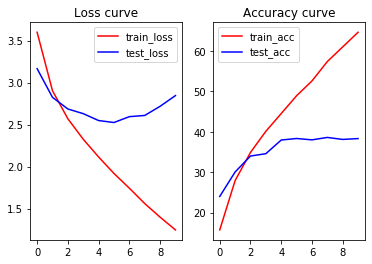

In [10]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'maxpool',bn = False, dropout = False, loss_type = 'cross_entropy')

##### Using Average Pooling

Train : [1] loss: 3.651 Accuracy: 14.82
Test : [1] loss: 3.277 Accuracy: 21.49
Train : [2] loss: 3.045 Accuracy: 25.08
Test : [2] loss: 2.986 Accuracy: 27.47
Train : [3] loss: 2.753 Accuracy: 31.08
Test : [3] loss: 2.834 Accuracy: 31.03
Train : [4] loss: 2.531 Accuracy: 35.61
Test : [4] loss: 2.761 Accuracy: 32.40
Train : [5] loss: 2.344 Accuracy: 39.52
Test : [5] loss: 2.702 Accuracy: 33.89
Train : [6] loss: 2.168 Accuracy: 43.51
Test : [6] loss: 2.710 Accuracy: 34.54
Train : [7] loss: 2.003 Accuracy: 47.00
Test : [7] loss: 2.804 Accuracy: 34.44
Train : [8] loss: 1.847 Accuracy: 50.48
Test : [8] loss: 2.769 Accuracy: 35.21
Train : [9] loss: 1.697 Accuracy: 53.83
Test : [9] loss: 2.877 Accuracy: 35.36
Train : [10] loss: 1.555 Accuracy: 57.31
Test : [10] loss: 2.945 Accuracy: 34.89


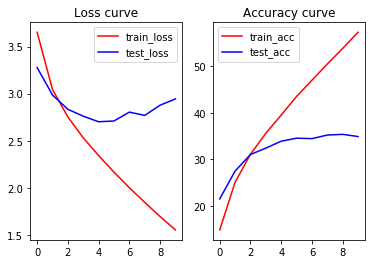

In [11]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'avgpool',bn = False, dropout = False, loss_type = 'cross_entropy')

##### Using L1 Pooling

Train : [1] loss: 3.523 Accuracy: 17.44
Test : [1] loss: 3.090 Accuracy: 24.44
Train : [2] loss: 2.844 Accuracy: 29.34
Test : [2] loss: 2.835 Accuracy: 30.52
Train : [3] loss: 2.504 Accuracy: 36.30
Test : [3] loss: 2.746 Accuracy: 33.19
Train : [4] loss: 2.236 Accuracy: 41.62
Test : [4] loss: 2.719 Accuracy: 33.81
Train : [5] loss: 1.999 Accuracy: 47.09
Test : [5] loss: 2.697 Accuracy: 35.01
Train : [6] loss: 1.774 Accuracy: 51.69
Test : [6] loss: 2.793 Accuracy: 34.72
Train : [7] loss: 1.568 Accuracy: 56.77
Test : [7] loss: 2.970 Accuracy: 34.45
Train : [8] loss: 1.371 Accuracy: 61.54
Test : [8] loss: 3.111 Accuracy: 34.17
Train : [9] loss: 1.195 Accuracy: 65.56
Test : [9] loss: 3.354 Accuracy: 33.79
Train : [10] loss: 1.027 Accuracy: 69.85
Test : [10] loss: 3.633 Accuracy: 32.89


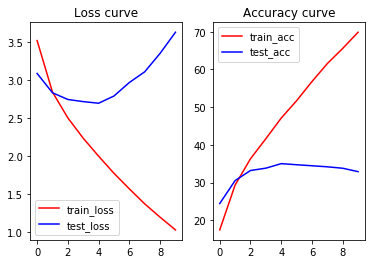

In [12]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'l1pool',bn = False, dropout = False, loss_type = 'cross_entropy')

##### Using L2 Pooling

Train : [1] loss: 3.576 Accuracy: 16.28
Test : [1] loss: 3.114 Accuracy: 24.19
Train : [2] loss: 2.878 Accuracy: 28.60
Test : [2] loss: 2.831 Accuracy: 31.16
Train : [3] loss: 2.559 Accuracy: 34.96
Test : [3] loss: 2.656 Accuracy: 34.08
Train : [4] loss: 2.312 Accuracy: 40.18
Test : [4] loss: 2.597 Accuracy: 35.91
Train : [5] loss: 2.116 Accuracy: 44.67
Test : [5] loss: 2.568 Accuracy: 37.01
Train : [6] loss: 1.927 Accuracy: 48.64
Test : [6] loss: 2.582 Accuracy: 36.95
Train : [7] loss: 1.759 Accuracy: 52.52
Test : [7] loss: 2.667 Accuracy: 36.56
Train : [8] loss: 1.591 Accuracy: 56.47
Test : [8] loss: 2.717 Accuracy: 37.14
Train : [9] loss: 1.453 Accuracy: 59.72
Test : [9] loss: 2.878 Accuracy: 37.23
Train : [10] loss: 1.308 Accuracy: 63.20
Test : [10] loss: 2.942 Accuracy: 36.79


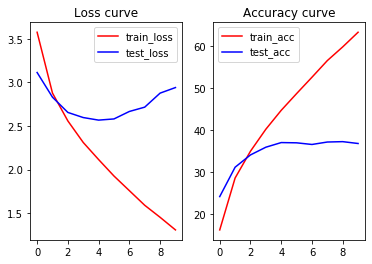

In [13]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'l2pool',bn = False, dropout = False, loss_type = 'cross_entropy')

### Changing usage of Batch Normalisation

* Loss = CrossEntropy
* No Dropout
* Max Pooling
* *Comparison with previous instance of no Batch Normalisation*

##### Using Batch Normalisation

Train : [1] loss: 3.333 Accuracy: 20.31
Test : [1] loss: 2.859 Accuracy: 28.91
Train : [2] loss: 2.575 Accuracy: 34.47
Test : [2] loss: 2.551 Accuracy: 35.59
Train : [3] loss: 2.277 Accuracy: 40.96
Test : [3] loss: 2.401 Accuracy: 38.34
Train : [4] loss: 2.059 Accuracy: 45.43
Test : [4] loss: 2.407 Accuracy: 39.35
Train : [5] loss: 1.877 Accuracy: 49.66
Test : [5] loss: 2.299 Accuracy: 41.74
Train : [6] loss: 1.730 Accuracy: 53.34
Test : [6] loss: 2.308 Accuracy: 41.67
Train : [7] loss: 1.588 Accuracy: 56.42
Test : [7] loss: 2.377 Accuracy: 41.60
Train : [8] loss: 1.460 Accuracy: 59.56
Test : [8] loss: 2.427 Accuracy: 41.29
Train : [9] loss: 1.351 Accuracy: 62.09
Test : [9] loss: 2.473 Accuracy: 41.76
Train : [10] loss: 1.231 Accuracy: 65.22
Test : [10] loss: 2.552 Accuracy: 41.35


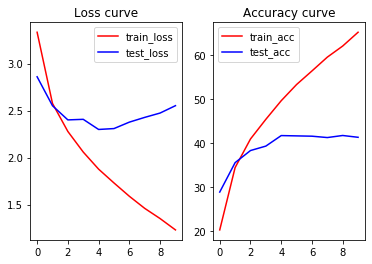

In [14]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'maxpool',bn = True, dropout = False, loss_type = 'cross_entropy')

### Changing usage of Dropout

* Loss = CrossEntropy
* No Batch Normalisation
* Max Pooling
* Dropout with probability = 0.2
* *Comparison with previous instance of no Dropout*

Train : [1] loss: 3.744 Accuracy: 13.40
Test : [1] loss: 3.264 Accuracy: 22.40
Train : [2] loss: 3.171 Accuracy: 23.18
Test : [2] loss: 2.961 Accuracy: 27.76
Train : [3] loss: 2.903 Accuracy: 28.52
Test : [3] loss: 2.799 Accuracy: 31.09
Train : [4] loss: 2.711 Accuracy: 32.40
Test : [4] loss: 2.675 Accuracy: 33.96
Train : [5] loss: 2.559 Accuracy: 35.23
Test : [5] loss: 2.609 Accuracy: 35.14
Train : [6] loss: 2.428 Accuracy: 37.91
Test : [6] loss: 2.567 Accuracy: 36.00
Train : [7] loss: 2.318 Accuracy: 40.43
Test : [7] loss: 2.560 Accuracy: 36.71
Train : [8] loss: 2.209 Accuracy: 42.82
Test : [8] loss: 2.518 Accuracy: 37.67
Train : [9] loss: 2.116 Accuracy: 44.41
Test : [9] loss: 2.517 Accuracy: 37.73
Train : [10] loss: 2.022 Accuracy: 46.78
Test : [10] loss: 2.537 Accuracy: 37.98


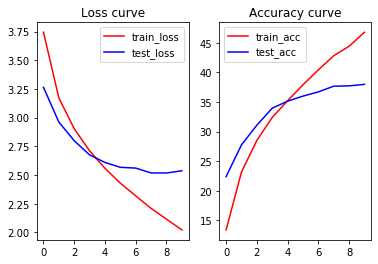

In [15]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'maxpool',bn = False, dropout = True, loss_type = 'cross_entropy')

### Changing Loss Functions

* No Batch Normalisation
* No Dropout
* Max Pooling

##### Using L1 loss

Train : [1] loss: 1.954 Accuracy: 2.46
Test : [1] loss: 1.971 Accuracy: 2.28
Train : [2] loss: 1.953 Accuracy: 2.50
Test : [2] loss: 1.954 Accuracy: 3.10
Train : [3] loss: 1.940 Accuracy: 3.18
Test : [3] loss: 1.943 Accuracy: 3.62
Train : [4] loss: 1.941 Accuracy: 3.09
Test : [4] loss: 1.945 Accuracy: 3.53
Train : [5] loss: 1.933 Accuracy: 3.52
Test : [5] loss: 1.943 Accuracy: 3.64
Train : [6] loss: 1.928 Accuracy: 3.75
Test : [6] loss: 1.934 Accuracy: 4.06
Train : [7] loss: 1.931 Accuracy: 3.60
Test : [7] loss: 1.942 Accuracy: 3.68
Train : [8] loss: 1.935 Accuracy: 3.42
Test : [8] loss: 1.947 Accuracy: 3.46
Train : [9] loss: 1.936 Accuracy: 3.36
Test : [9] loss: 1.945 Accuracy: 3.50
Train : [10] loss: 1.933 Accuracy: 3.50
Test : [10] loss: 1.948 Accuracy: 3.46


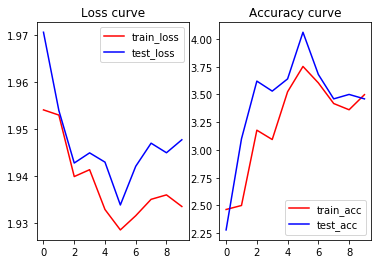

In [29]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'maxpool',bn = False, dropout = True, loss_type = 'l1')

##### Using L2 loss

Train : [1] loss: 0.966 Accuracy: 9.00
Test : [1] loss: 0.943 Accuracy: 14.67
Train : [2] loss: 0.933 Accuracy: 15.50
Test : [2] loss: 0.912 Accuracy: 19.74
Train : [3] loss: 0.903 Accuracy: 19.75
Test : [3] loss: 0.886 Accuracy: 22.28
Train : [4] loss: 0.879 Accuracy: 23.34
Test : [4] loss: 0.860 Accuracy: 25.94
Train : [5] loss: 0.861 Accuracy: 25.70
Test : [5] loss: 0.848 Accuracy: 27.53
Train : [6] loss: 0.842 Accuracy: 27.84
Test : [6] loss: 0.834 Accuracy: 29.43
Train : [7] loss: 0.827 Accuracy: 29.65
Test : [7] loss: 0.832 Accuracy: 29.58
Train : [8] loss: 0.811 Accuracy: 31.50
Test : [8] loss: 0.818 Accuracy: 31.61
Train : [9] loss: 0.797 Accuracy: 33.14
Test : [9] loss: 0.811 Accuracy: 32.37
Train : [10] loss: 0.782 Accuracy: 34.87
Test : [10] loss: 0.811 Accuracy: 32.39


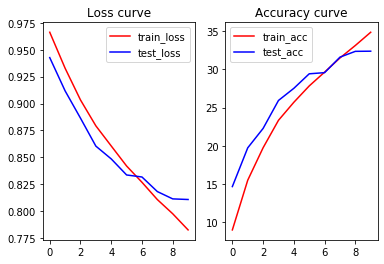

In [30]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'maxpool',bn = False, dropout = True, loss_type = 'l2')

### Changing Number of Fully Connected Layers

* Using Batch Normalisation
* Using Dropout of probability = 0.2
* Using Max Pooling
* Using Cross Entropy Loss

##### Using 1 Fully connected Layer

Train : [1] loss: 3.571 Accuracy: 15.91
Test : [1] loss: 3.045 Accuracy: 25.95
Train : [2] loss: 2.961 Accuracy: 26.77
Test : [2] loss: 2.755 Accuracy: 31.87
Train : [3] loss: 2.686 Accuracy: 32.53
Test : [3] loss: 2.561 Accuracy: 35.26
Train : [4] loss: 2.495 Accuracy: 36.58
Test : [4] loss: 2.469 Accuracy: 37.47
Train : [5] loss: 2.354 Accuracy: 39.50
Test : [5] loss: 2.419 Accuracy: 38.45
Train : [6] loss: 2.229 Accuracy: 42.18
Test : [6] loss: 2.390 Accuracy: 39.36
Train : [7] loss: 2.132 Accuracy: 44.14
Test : [7] loss: 2.383 Accuracy: 39.31
Train : [8] loss: 2.034 Accuracy: 46.27
Test : [8] loss: 2.335 Accuracy: 40.91
Train : [9] loss: 1.969 Accuracy: 47.88
Test : [9] loss: 2.341 Accuracy: 40.87
Train : [10] loss: 1.884 Accuracy: 49.93
Test : [10] loss: 2.368 Accuracy: 40.50


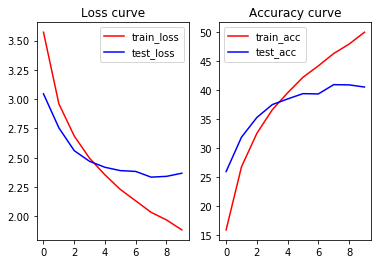

In [19]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,100],padding_list = [1,0],pool_type = 'maxpool',bn = True, dropout = True, loss_type = 'cross_entropy')

##### Using 2 Fully connected Layers

Train : [1] loss: 3.921 Accuracy: 9.78
Test : [1] loss: 3.544 Accuracy: 16.10
Train : [2] loss: 3.377 Accuracy: 18.34
Test : [2] loss: 3.180 Accuracy: 23.20
Train : [3] loss: 3.124 Accuracy: 23.35
Test : [3] loss: 3.014 Accuracy: 26.23
Train : [4] loss: 2.947 Accuracy: 26.67
Test : [4] loss: 2.840 Accuracy: 29.69
Train : [5] loss: 2.793 Accuracy: 29.80
Test : [5] loss: 2.771 Accuracy: 31.39
Train : [6] loss: 2.671 Accuracy: 32.17
Test : [6] loss: 2.749 Accuracy: 32.59
Train : [7] loss: 2.568 Accuracy: 34.12
Test : [7] loss: 2.633 Accuracy: 33.87
Train : [8] loss: 2.468 Accuracy: 36.30
Test : [8] loss: 2.607 Accuracy: 35.02
Train : [9] loss: 2.380 Accuracy: 38.43
Test : [9] loss: 2.559 Accuracy: 35.89
Train : [10] loss: 2.297 Accuracy: 40.09
Test : [10] loss: 2.572 Accuracy: 35.55


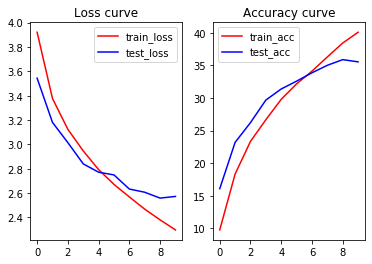

In [20]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,256,100],padding_list = [1,0],pool_type = 'maxpool',bn = False, dropout = True, loss_type = 'cross_entropy')

##### Using 3 Fully connected Layers

Train : [1] loss: 4.078 Accuracy: 6.93
Test : [1] loss: 3.749 Accuracy: 11.25
Train : [2] loss: 3.569 Accuracy: 14.58
Test : [2] loss: 3.345 Accuracy: 18.73
Train : [3] loss: 3.265 Accuracy: 19.88
Test : [3] loss: 3.087 Accuracy: 24.00
Train : [4] loss: 3.047 Accuracy: 23.98
Test : [4] loss: 2.904 Accuracy: 27.93
Train : [5] loss: 2.862 Accuracy: 27.77
Test : [5] loss: 2.841 Accuracy: 29.41
Train : [6] loss: 2.734 Accuracy: 30.34
Test : [6] loss: 2.718 Accuracy: 31.60
Train : [7] loss: 2.612 Accuracy: 32.87
Test : [7] loss: 2.633 Accuracy: 33.38
Train : [8] loss: 2.501 Accuracy: 35.09
Test : [8] loss: 2.613 Accuracy: 34.27
Train : [9] loss: 2.405 Accuracy: 37.19
Test : [9] loss: 2.573 Accuracy: 35.19
Train : [10] loss: 2.326 Accuracy: 38.68
Test : [10] loss: 2.543 Accuracy: 35.88


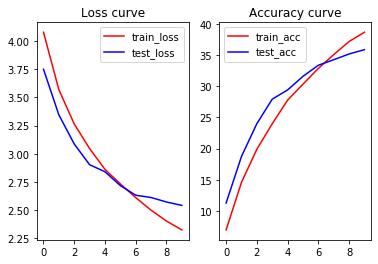

In [21]:
run(in_size = 32,channels_list = [3,16,32],kernels_list = [3,5],strides_list = 1, lin_list = [512,256,128,100],padding_list = [1,0],pool_type = 'maxpool',bn = False, dropout = True, loss_type = 'cross_entropy')